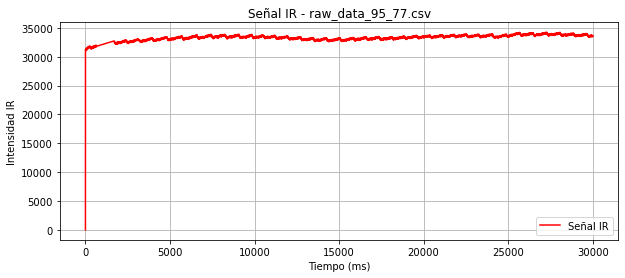

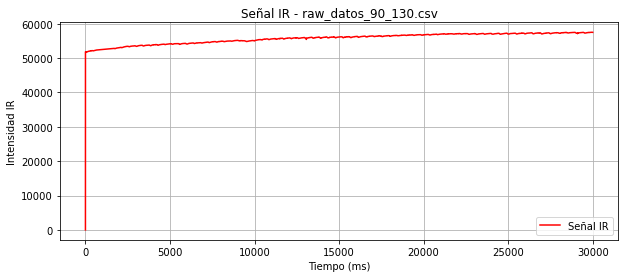

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

ruta_csv = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log"

archivos = glob.glob(os.path.join(ruta_csv, "*.csv"))

# Iterar sobre cada archivo y graficar la señal IR
for archivo in archivos:
    # Cargar datos
    df = pd.read_csv(archivo, delimiter=";")

    # Verificar que la columna "IR" existe
    if "IR" not in df.columns:
        print(f"Advertencia: No se encontró la columna 'IR' en {archivo}")
        continue

    # Graficar la señal IR
    plt.figure(figsize=(10, 4))
    plt.plot(df["Tiempo (ms)"], df["IR"], label="Señal IR", color="red")
    plt.xlabel("Tiempo (ms)")
    plt.ylabel("Intensidad IR")
    plt.title(f"Señal IR - {os.path.basename(archivo)}")
    plt.legend()
    plt.grid()
    plt.show()


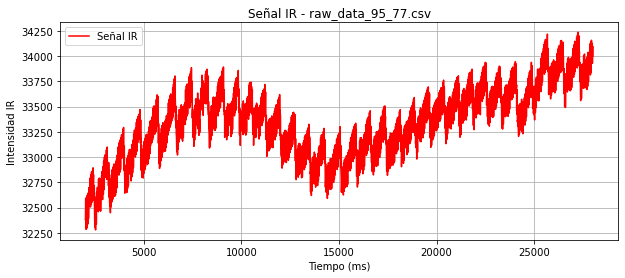

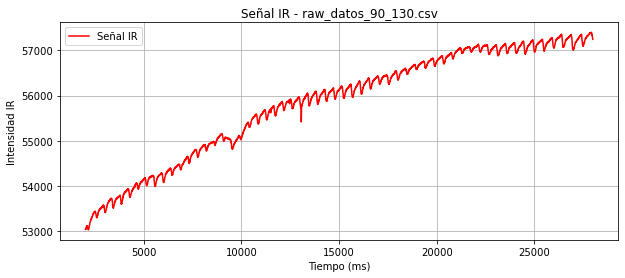

In [2]:
import os
import glob
import pandas as pd

ruta_csv = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log"

archivos = glob.glob(os.path.join(ruta_csv, "*.csv"))

for archivo in archivos:
    df = pd.read_csv(archivo, delimiter=";")
    
    columnas_requeridas = ["Tiempo (ms)", "IR", "AMB_IR", "RED", "AMB_RED"]
    if not all(col in df.columns for col in columnas_requeridas):
        print(f"Advertencia: El archivo {archivo} no tiene las columnas esperadas. Se omite.")
        continue
    
    df["Tiempo (s)"] = (df["Tiempo (ms)"] - df["Tiempo (ms)"].iloc[0]) / 1000  # Normalizar a segundos
    
    tiempo_inicio = df["Tiempo (s)"].iloc[0] + 2
    tiempo_fin = df["Tiempo (s)"].iloc[-1] - 2
    df_recortado = df[(df["Tiempo (s)"] >= tiempo_inicio) & (df["Tiempo (s)"] <= tiempo_fin)]
    
    df_recortado = df_recortado.drop(columns=["Tiempo (s)"])
    
    # Graficar la señal IR
    plt.figure(figsize=(10, 4))
    plt.plot(df_recortado["Tiempo (ms)"], df_recortado["IR"], label="Señal IR", color="red")
    plt.xlabel("Tiempo (ms)")
    plt.ylabel("Intensidad IR")
    plt.title(f"Señal IR - {os.path.basename(archivo)}")
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
fs = 1 / df_recortado["Tiempo (ms)"].diff().median()
fs

1.0

In [4]:
dt_medio = df_recortado["Tiempo (ms)"].diff().median()
fs = 1000 / dt_medio  # Convertir de ms a Hz
print(f"Tiempo medio entre muestras: {dt_medio} ms")
print(f"Frecuencia de muestreo estimada: {fs} Hz")


Tiempo medio entre muestras: 1.0 ms
Frecuencia de muestreo estimada: 1000.0 Hz


In [5]:
# Verificar duración del archivo original
duracion_total = (df["Tiempo (ms)"].iloc[-1] - df["Tiempo (ms)"].iloc[0]) / 1000
print(f"Duración total de la señal antes del recorte: {duracion_total:.2f} segundos")

# Verificar si el recorte deja datos suficientes
tiempo_inicio = df["Tiempo (ms)"].iloc[0] + 5000  # +5s
tiempo_fin = df["Tiempo (ms)"].iloc[-1] - 5000    # -5s

df_recortado = df[(df["Tiempo (ms)"] >= tiempo_inicio) & (df["Tiempo (ms)"] <= tiempo_fin)]

# Si la cantidad de datos después del recorte es menor a 15, mostramos advertencia
if len(df_recortado) < 15:
    print(f" Advertencia: Tras el recorte, quedan solo {len(df_recortado)} muestras. Ajusta el recorte o usa la señal completa.")


Duración total de la señal antes del recorte: 30.00 segundos


In [6]:
import pandas as pd

# Cargar archivo (usa tu variable `archivo` aquí)
df = pd.read_csv(archivo, delimiter=";")

# Verificar duración antes del recorte
duracion_total = (df["Tiempo (ms)"].iloc[-1] - df["Tiempo (ms)"].iloc[0]) / 1000
print(f"Duración total antes del recorte: {duracion_total:.2f} segundos")

# Definir tiempos de recorte
tiempo_inicio = df["Tiempo (ms)"].iloc[0] + 5000
tiempo_fin = df["Tiempo (ms)"].iloc[-1] - 5000

# Aplicar recorte
df_recortado = df[(df["Tiempo (ms)"] >= tiempo_inicio) & (df["Tiempo (ms)"] <= tiempo_fin)]

# Depuración: Mostrar primeras y últimas filas
print("\nPrimeras filas de df_recortado:")
print(df_recortado.head())

print("\nÚltimas filas de df_recortado:")
print(df_recortado.tail())

# Verificar tamaño después del recorte
if len(df_recortado) == 0:
    print("Error: df_recortado quedó vacío. Revisemos los tiempos en el dataset original:")
    print(df[["Tiempo (ms)"]].head(10))  # Primeros 10 valores
    print(df[["Tiempo (ms)"]].tail(10))  # Últimos 10 valores


Duración total antes del recorte: 30.00 segundos

Primeras filas de df_recortado:
      Tiempo (ms)     IR  AMB_IR    RED  AMB_RED
1636         5002  54137    1414  42908     1380
1637         5002  54137    1414  42908     1380
1638         5003  54154    1422  42908     1380
1639         5003  54154    1422  42908     1380
1640         5004  54154    1422  42931     1386

Últimas filas de df_recortado:
      Tiempo (ms)     IR  AMB_IR    RED  AMB_RED
9624        24991  57002    1177  45183     1145
9625        24992  56995    1177  45183     1145
9626        24992  56995    1181  45183     1145
9627        24993  56995    1181  45175     1145
9628        24993  56995    1181  45175     1148


In [8]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt


# Copia segura del DataFrame para evitar advertencias
df_recortado = df_recortado.copy()

# Aplicar el filtro sin warnings
df_recortado["IR_filtrada"] = signal.filtfilt(b, a, df_recortado["IR"])


# Definir parámetros del filtro paso bajo
fs = 1000  # Frecuencia de muestreo (estimada antes)
lowcut = 5  # Frecuencia de corte (5 Hz, ajustable)
order = 4   # Orden del filtro

# Diseñar filtro Butterworth
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Aplicar el filtro
b, a = butter_lowpass(lowcut, fs, order)
df_recortado["IR_filtrada"] = signal.filtfilt(b, a, df_recortado["IR"])

# Graficar señal original vs filtrada
plt.figure(figsize=(10, 5))
plt.plot(df_recortado["Tiempo (ms)"], df_recortado["IR"], label="Señal IR original", alpha=0.5)
plt.plot(df_recortado["Tiempo (ms)"], df_recortado["IR_filtrada"], label="Señal IR filtrada", color="red")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad IR")
plt.title("Señal IR antes y después del filtrado")
plt.legend()
plt.grid()
plt.show()


NameError: name 'b' is not defined

In [ ]:
from scipy.signal import find_peaks

# Detectar los picos en la señal filtrada (con un mínimo de altura de 0.5, ajustable)
peaks, _ = find_peaks(df_recortado["IR_filtrada"], height=0.5)

# Calcular los tiempos en segundos de los picos
tiempos_picos = df_recortado["Tiempo (ms)"].iloc[peaks] / 1000  # Convertir a segundos

# Calcular el intervalo medio entre picos en segundos
intervalo_picos = np.diff(tiempos_picos).mean()

# Calcular la frecuencia cardíaca (HR) en latidos por minuto (bpm)
hr_estimada = 60 / intervalo_picos

# Mostrar resultados
print(f"Frecuencia cardíaca estimada: {hr_estimada:.2f} bpm")
